<a href="https://colab.research.google.com/github/KevinDLopez/MammographyAI/blob/main/src/GoogLetNetV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

# from utils.data_download import download_data_with_animation, unzip_data
# from utils.read_tensorflow_data import read_tf_data, data_type, create_tf_dataset
# from utils.plotting import plot_histories
import os
from typing import List, Tuple, TypedDict, Dict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from keras.models import Sequential
from keras import layers, models
from keras.callbacks import ModelCheckpoint
from keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    concatenate,
    Dropout,
    Dense,
    Flatten,
    BatchNormalization,
    Activation,
    AveragePooling2D,
    Add,
    Dropout,
    MaxPool2D,
    GlobalAveragePooling2D,
)
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.metrics import Recall
from keras.metrics import Precision

In [ ]:
data_dir = '/kaggle/input/ddsm-mammography/'

In [ ]:
import tensorflow as tf
from typing import List, Tuple, TypedDict
import numpy as np

data_type = TypedDict("data_type", {"label": List[np.number], "data": List[tf.Tensor]})


def read_tf_data(file: str, storing_dict: data_type):
    def parse_function(example_proto):
        return tf.io.parse_single_example(
            example_proto,
            {
                "label": tf.io.FixedLenFeature([], tf.int64),
                "label_normal": tf.io.FixedLenFeature([], tf.int64),
                "image": tf.io.FixedLenFeature([], tf.string),
            },
        )

    # Extract the data
    with tf.device("/CPU:0"):  # else is filled with GPU memory # type: ignore
        raw_data = tf.data.TFRecordDataset([file])
        parsed_dataset = raw_data.map(parse_function)

    for element in parsed_dataset:
        with tf.device("/CPU:0"):  # else is filled with GPU memory # type: ignore
            image = tf.io.decode_raw(
                element["image"], tf.uint8
            )  # shape = (89401,0) - 299*299 = 89401
            image = tf.reshape(image, [299, 299, 1])  # gray scale image
            label = np.int8(element["label_normal"].numpy())
            storing_dict["label"].append(label)
            storing_dict["data"].append(image)


# allocating the data to the memory, with a small batch size. Previously the training was not happening.
def create_tf_dataset(data_dict):
    def generator(data, labels):
        for d, l in zip(data, labels):
            yield d, l

    # Convert the data to TensorFlow Datasets
    dataset = tf.data.Dataset.from_generator(
        generator,
        args=[data_dict["data"], data_dict["label"]],
        output_signature=(
            tf.TensorSpec(shape=(299, 299, 1), dtype=tf.uint8),  # type: ignore
            tf.TensorSpec(shape=(), dtype=tf.uint8),  # type: ignore
        ),
    )
    dataset = dataset.shuffle(buffer_size=512)

    return dataset



import matplotlib.pyplot as plt
from typing import List, Tuple, TypedDict, Dict

def plot_histories(histories:List[ Dict[str, List[int]]], log_scale=False):
    '''Plot the training and validation loss and accuracy of the models in the histories list
    histories: List of histories dictionaries
    '''
    plt.figure(figsize=(10, 15))

    history_dictionary : Dict[str, List[int] ]  = {}
    # make a whole array from the elements of the dictionary
    for history in histories:
        for plt_name, values in history.items():
            if plt_name not in history_dictionary:
                history_dictionary[plt_name] = []
            history_dictionary[plt_name].extend(values)


    plt.subplot(len(history_dictionary)//2,1,1)
    plt.title('Loss')
    plt.plot(history_dictionary['loss'], label='Training Loss')
    plt.plot(history_dictionary['val_loss'], label='Validation Loss')
    if log_scale:
        plt.yscale("log")
    plt.legend()

    plt.subplot(len(history_dictionary)//2,1,2)
    plt.title('Accuracy')
    plt.plot(history_dictionary['accuracy'], label='Training Accuracy')
    plt.plot(history_dictionary['val_accuracy'], label='Validation Accuracy')
    if log_scale:
        plt.yscale("log")
    plt.legend()

    plt.subplot(len(history_dictionary)//2,1,3)
    plt.title("Recall")
    plt.plot(history_dictionary['recall'], label='Training Recall')
    plt.plot(history_dictionary['val_recall'], label='Validation Recall')
    if log_scale:
        plt.yscale("log")
    plt.legend()

    if "precision" in history_dictionary:
        plt.subplot(len(history_dictionary)//2,1,4)
        plt.title("precision")
        plt.plot(history_dictionary['precision'], label='Training precision')
        plt.plot(history_dictionary['val_precision'], label='Validation precision')
        if log_scale:
            plt.yscale("log")
        plt.legend()


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ddsm-mammography/cv10_labels.npy
/kaggle/input/ddsm-mammography/test10_labels.npy
/kaggle/input/ddsm-mammography/training10_0/training10_0.tfrecords
/kaggle/input/ddsm-mammography/training10_4/training10_4.tfrecords
/kaggle/input/ddsm-mammography/cv10_data/cv10_data.npy
/kaggle/input/ddsm-mammography/test10_data/test10_data.npy
/kaggle/input/ddsm-mammography/training10_2/training10_2.tfrecords
/kaggle/input/ddsm-mammography/training10_3/training10_3.tfrecords
/kaggle/input/ddsm-mammography/training10_1/training10_1.tfrecords


In [ ]:
data_files = []
for root, dirs, files in os.walk("/kaggle/input") :
	for file in files:
		data_files.append( os.path.join(root, file).replace('\\', '/') )

data_files


['/kaggle/input/ddsm-mammography/cv10_labels.npy',
 '/kaggle/input/ddsm-mammography/test10_labels.npy',
 '/kaggle/input/ddsm-mammography/training10_0/training10_0.tfrecords',
 '/kaggle/input/ddsm-mammography/training10_4/training10_4.tfrecords',
 '/kaggle/input/ddsm-mammography/cv10_data/cv10_data.npy',
 '/kaggle/input/ddsm-mammography/test10_data/test10_data.npy',
 '/kaggle/input/ddsm-mammography/training10_2/training10_2.tfrecords',
 '/kaggle/input/ddsm-mammography/training10_3/training10_3.tfrecords',
 '/kaggle/input/ddsm-mammography/training10_1/training10_1.tfrecords']

In [ ]:
training_files = [file for file in data_files if "training" in file]
training_files

['/kaggle/input/ddsm-mammography/training10_0/training10_0.tfrecords',
 '/kaggle/input/ddsm-mammography/training10_4/training10_4.tfrecords',
 '/kaggle/input/ddsm-mammography/training10_2/training10_2.tfrecords',
 '/kaggle/input/ddsm-mammography/training10_3/training10_3.tfrecords',
 '/kaggle/input/ddsm-mammography/training10_1/training10_1.tfrecords']

In [ ]:
training_data :data_type = {"label": [], "data": []}

for training_file in training_files:
	read_tf_data( training_file, training_data )

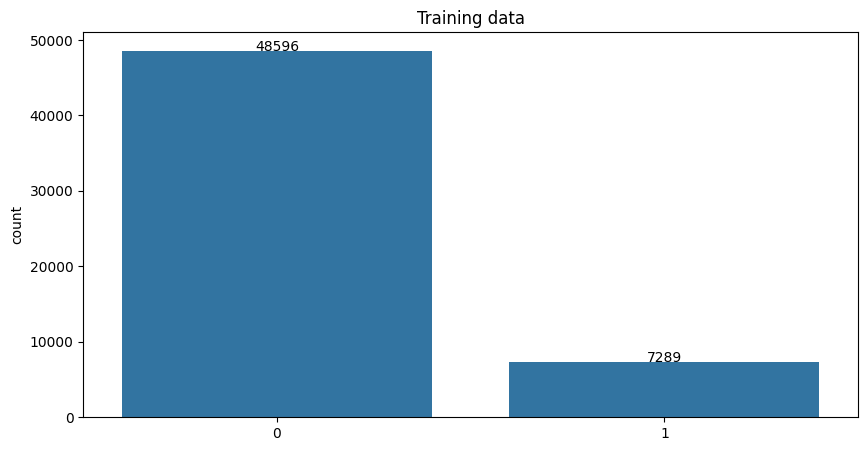

In [ ]:
plt.figure(figsize=(10, 5))

sns.countplot(x=training_data['label'])
plt.title("Training data")
# add labels on top of the data
# add labels on top of the data( note there is only 2 cathegories 1, 0)
for i in range(2):
	plt.text(i, training_data['label'].count(i), training_data['label'].count(i), ha = 'center')  # type: ignore
plt.show()


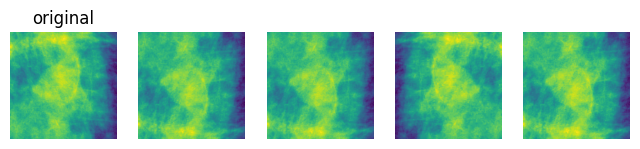

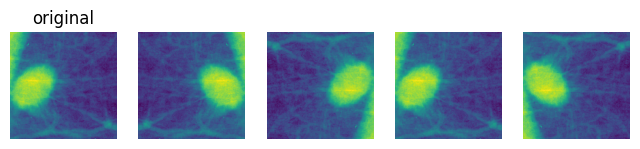

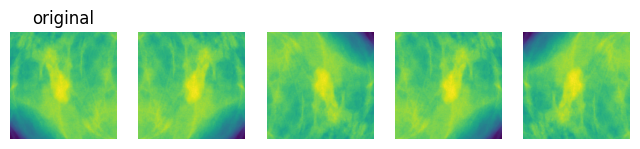

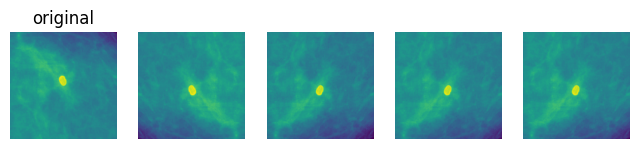

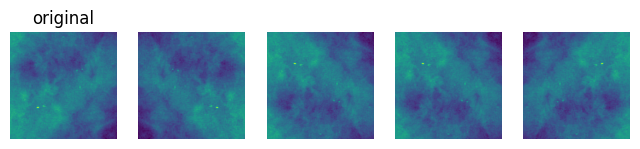

In [ ]:
def augment(image, lower_c=0.8, high_c=1.0)-> tf.Tensor:
    with tf.device("/CPU:0"):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.25)
        image = tf.image.random_contrast(image, lower=lower_c, upper=high_c)
        image = tf.image.random_jpeg_quality(image, min_jpeg_quality=70, max_jpeg_quality=100)
        return image # type: ignore

augmented_images = []
augmented_labels = []
shown_once = 0
for label, image in zip(training_data["label"], training_data["data"]):
    # augment 3, positive, 1 negative
    if label == 1:
        img1 = augment(image)
        img2 = augment(image, lower_c=1, high_c=1.3)
        img3 = augment(image, lower_c=0.8, high_c=1.2)
        img4 = augment(image, lower_c=0.8, high_c=1.2)
        augmented_images.extend([img1,img2, img3, img4 ])
        augmented_labels.extend([label, label,label, label])
        if shown_once<5: # To only show images once
            shown_once +=1
            plt.figure(figsize=(8, 3))
            plt.subplot(1, 5, 1)
            plt.imshow(image)
            plt.title('original')
            plt.axis("off")
            plt.subplot(1, 5, 2)
            plt.imshow(img1)
            plt.axis("off")
            plt.subplot(1, 5, 3)
            plt.imshow(img2)
            plt.axis("off")
            plt.subplot(1, 5, 4)
            plt.imshow(img3)
            plt.axis("off")
            plt.subplot(1, 5, 5)
            plt.imshow(img4)
            plt.axis("off")
            plt.show()
    img5 = augment(image)
    augmented_images.extend([img5])
    augmented_labels.extend([label])

training_data["label"].extend(augmented_labels)
training_data["data"].extend(augmented_images)

In [ ]:
import random

def shuffle(data_labels:data_type):
    # Create a list of indices from 0 to the length of data
    indices = list(range(len(data_labels['data'])))

    # Shuffle the indices
    random.shuffle(indices)

    # Use the shuffled indices to reorder data and labels
    shuffled_data = [data_labels['data'][i] for i in indices]
    shuffled_labels = [data_labels["label"][i] for i in indices]

    return shuffled_data, shuffled_labels

training_data['data'], training_data["label"] = shuffle(training_data)
training_data['data'], training_data["label"] = shuffle(training_data) # shuffle twice for better

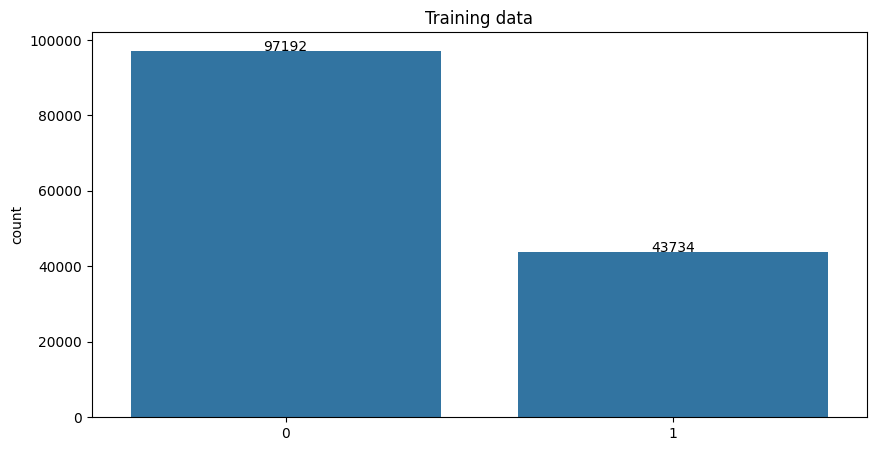

In [ ]:
plt.figure(figsize=(10, 5))

sns.countplot(x=training_data['label'])
plt.title("Training data")
# add labels on top of the data
# add labels on top of the data( note there is only 2 cathegories 1, 0)
for i in range(2):
	plt.text(i, training_data['label'].count(i), training_data['label'].count(i), ha = 'center')  # type: ignore
plt.show()


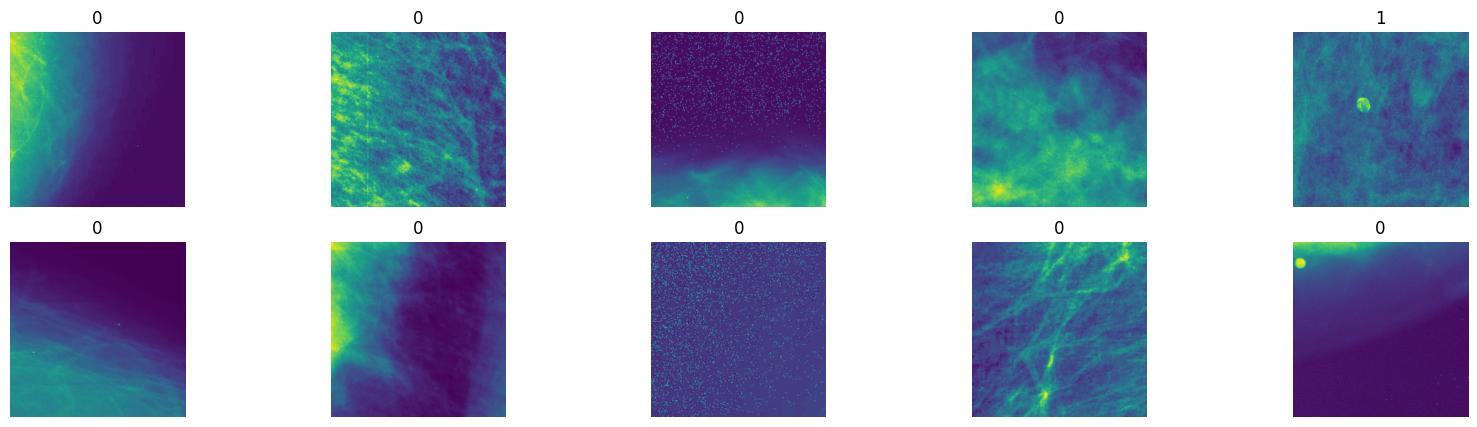

In [ ]:
nrows = 2
ncols = 5

plt.figure(figsize=(20, 5))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(training_data["data"][i], )
    plt.title(str(training_data["label"][i]))
    # Remove the axis
    plt.axis('off')

# Show the plot
# plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.show()


In [ ]:
test_files =  '/kaggle/input/ddsm-mammography/test10_data/test10_data.npy'
test_files_labels =  '/kaggle/input/ddsm-mammography/test10_labels.npy'

cross_validation_files =  '/kaggle/input/ddsm-mammography/cv10_data/cv10_data.npy'
cross_validation_files_labels = '/kaggle/input/ddsm-mammography/cv10_labels.npy'



# Note this data is ng, cv_data only contains masses, test_data only contains calcifications.
test_data_ng = np.load( test_files)
test_data_labels = np.load(  test_files_labels)
cv_data_ng = np.load( cross_validation_files)
cv_data_labels = np.load( cross_validation_files_labels)


In [ ]:
#
cv_data : data_type = {'data': [], 'label': []}
test_data : data_type = {'data': [], 'label': []}
n_test = []  # data, label
n_cv = [] # data, label
for i in range( len(cv_data_ng)):
	if i%2: # odd
		n_test.append(   (cv_data_ng[i], cv_data_labels[i])   )
		n_test.append(   (test_data_ng[i], test_data_labels[i])   )
	else:
		n_cv.append(   (cv_data_ng[i], cv_data_labels[i])   )
		n_cv.append(   (test_data_ng[i], test_data_labels[i])   )

cv_data['data'] = [x[0] for x in n_cv]
cv_data['label'] = [np.int8(1) if x[1]>0 else np.int8(0) for x in n_cv]

test_data['data'] = [x[0] for x in n_test]
test_data['label'] = [np.int8(1) if x[1]>0 else np.int8(0) for x in n_test]

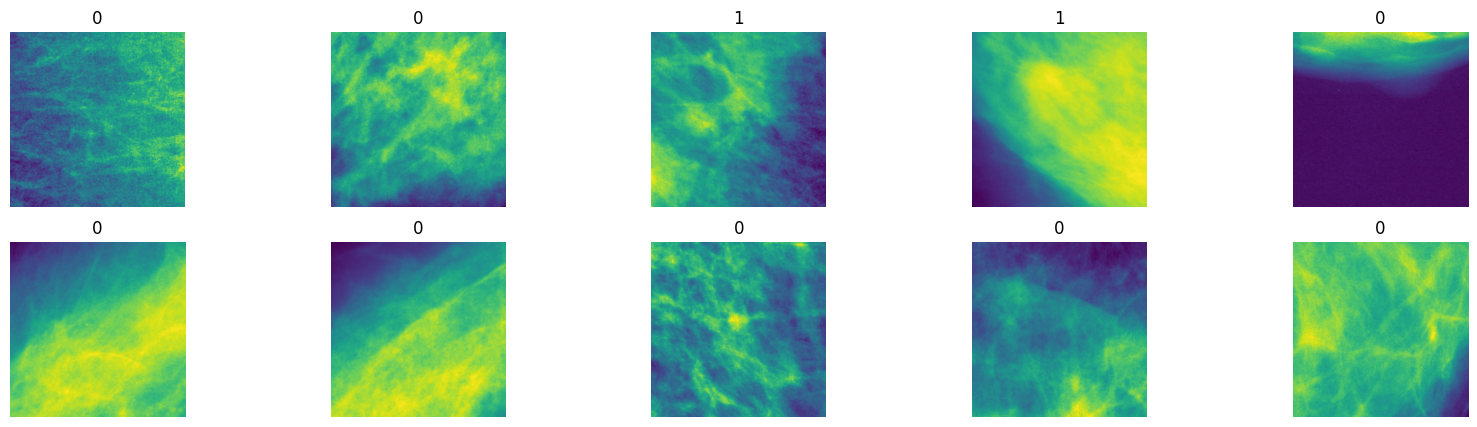

In [ ]:
nrows = 2
ncols = 5

plt.figure(figsize=(20, 5))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(cv_data["data"][i], )
    plt.title(str(cv_data["label"][i]))
    # Remove the axis
    plt.axis('off')

plt.show()

In [ ]:
train_dataset = create_tf_dataset(training_data).batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
cv_dataset = create_tf_dataset( cv_data).batch(32).prefetch(tf.data.AUTOTUNE)  # DatasetV2

In [ ]:
# Find the weights for each class
ones = 0
zeros = 0
for label in training_data['label']:
	if label == 1:
		ones += 1
	else:
		zeros += 1

total = ones + zeros

weights_dict = {0: (1/zeros) * (total/2), 1: (1/ones) * (total/2)}
weights_dict


{0: 0.7249876533047988, 1: 1.6111720857913752}

In [ ]:
print(f'ones = {ones}, zeros={zeros}, total={total}')

ones = 43734, zeros=97192, total=140926


In [ ]:

from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Dropout, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Add, MaxPool2D, GlobalAveragePooling2D
from keras.models import Model
# from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam, SGD
from keras import regularizers


reg = regularizers.l2(0.0001)

# 64, 96, 128, 16, 32, 192, 32
def inception_module_v3(x, filters:List[int], dropout_rate=0.2):
    # 1x1 convolution
    conv1x1 = None
    if filters[0]:
        conv1x1 = Conv2D(filters[0], (1, 1), padding='same',   )(x) # 299x299 x filter[0]
        conv1x1 = BatchNormalization()(conv1x1)                 # 299x299 x filter[0]
        conv1x1 = Activation('relu')(conv1x1)                   # 2

    conv3x3 = None
    # 3x3 convolution
    if filters[2] and filters[1]:
        conv3x3 = Conv2D(filters[1], (1, 1), padding='same', )(x)
        conv3x3 = BatchNormalization()(conv3x3)
        conv3x3 = Activation('relu')(conv3x3)
        conv3x3 = Conv2D(filters[2], (3, 3), padding='same', )(conv3x3)
        conv3x3 = BatchNormalization()(conv3x3)
        conv3x3 = Activation('relu')(conv3x3)
        conv3x3 = Dropout(dropout_rate)(conv3x3)  # Dropout added

    # Factored 5x5 convolution as two 3x3 convolutions
    conv5x5 = None
    if filters[3]!=0 and filters[4]!=0:
        conv5x5 = Conv2D(filters[3], (1, 1), padding='same')(x)
        conv5x5 = BatchNormalization()(conv5x5)
        conv5x5 = Activation('relu')(conv5x5)
        conv5x5 = Conv2D(filters[4], (3, 3), padding='same', )(conv5x5)
        conv5x5 = BatchNormalization()(conv5x5)
        conv5x5 = Activation('relu')(conv5x5)
        conv5x5 = Conv2D(filters[4], (3, 3), padding='same', )(conv5x5)
        conv5x5 = BatchNormalization()(conv5x5)
        conv5x5 = Activation('relu')(conv5x5)
        conv5x5 = Dropout(dropout_rate)(conv5x5)  # Dropout added

    # 7x7 convolution as three 3x3 convolutions
    conv7x7 = None
    if filters[5]!=0 and filters[6]!=0:
        conv7x7 = Conv2D( filters[5], (1,1), padding='same', )(x)
        conv7x7 = BatchNormalization()(conv7x7)
        conv7x7 = Activation('relu')(conv7x7)
        conv7x7 = Conv2D(filters[6], (3,3), padding='same', )(x)
        conv7x7 = BatchNormalization()(conv7x7)
        conv7x7 = Activation('relu')(conv7x7)
        conv7x7 = Conv2D(filters[6], (3,3), padding='same', )(x)
        conv7x7 = BatchNormalization()(conv7x7)
        conv7x7 = Activation('relu')(conv7x7)
        conv7x7 = Conv2D(filters[6], (3,3), padding='same', )(x)
        conv7x7 = BatchNormalization()(conv7x7)
        conv7x7 = Activation('relu')(conv7x7)
        conv7x7 = Dropout(dropout_rate)(conv7x7)  # Dropout added


    # MaxPooling with 1x1 convolution projection
    pool_proj = None
    if filters[7]:
        pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
        pool_proj = Conv2D(filters[7], (1, 1), padding='same')(pool_proj)
        pool_proj = BatchNormalization()(pool_proj)
        pool_proj = Activation('relu')(pool_proj)
        pool_proj = Dropout(dropout_rate)(pool_proj)  # Dropout added

    conv5x5_real = None
    if len(filters)>8 and filters[8]:
        conv5x5_real = Conv2D(filters[8]//2, (5, 5), padding='same',  kernel_regularizer=reg )(x)
        conv5x5_real = BatchNormalization()(conv5x5_real)
        conv5x5_real = Activation('relu')(conv5x5_real)
        conv5x5_real = Conv2D(filters[8], (3, 3), padding='same',  kernel_regularizer=reg )(conv5x5_real)
        conv5x5_real = BatchNormalization()(conv5x5_real)
        conv5x5_real = Activation('relu')(conv5x5_real)
        conv5x5_real = Conv2D(filters[8], (1, 1), padding='same', )(conv5x5_real)
        conv5x5_real = BatchNormalization()(conv5x5_real)
        conv5x5_real = Activation('relu')(conv5x5_real)
        conv5x5_real = Dropout(dropout_rate)(conv5x5_real)  # Dropout added

    # Concatenate all the convolutions
    output_layers = [layer for layer in [conv1x1, conv5x5, conv3x3, conv7x7, pool_proj, conv5x5_real] if layer is not None]
    output = concatenate(output_layers)
    return output

def create_googlenet_v2()->Model:
    input_layer = Input(shape=(299, 299, 1))
    x = Conv2D(128, (5, 5),  strides=(2, 2), padding="same" )(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (5, 5),  padding="valid"  )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((5, 5), strides=(2, 2), padding='valid')(x)
    x = layers.Dropout(0.4)(x)

    # 64, 96, 128, 16, 32, 192, 32
    x = inception_module_v3(x, [64, 0, 0, 64, 32, 4, 8, 32, 64])
    x = AveragePooling2D((5, 5), strides=(3, 3), padding='same')(x)
    x = inception_module_v3(x, [0, 32, 64, 0, 0, 16, 64, 0])
    x = AveragePooling2D((5, 5), strides=(3, 3), padding='same')(x)
    x = inception_module_v3(x, [128, 0, 0, 64, 128, 32, 58, 32, 128])

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation='sigmoid', kernel_regularizer=reg)(x)  # Use sigmoid activation for binary classification
    model = Model(inputs=input_layer, outputs=x)
    return model

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


model_g_custom = create_googlenet_v2()
model_g_custom.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 299, 299, 1)]        0         []                            
                                                                                                  
 conv2d_232 (Conv2D)         (None, 150, 150, 128)        3328      ['input_5[0][0]']             
                                                                                                  
 batch_normalization_232 (B  (None, 150, 150, 128)        512       ['conv2d_232[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_232 (Activation  (None, 150, 150, 128)        0         ['batch_normalization_23

In [ ]:
model_g_custom = create_googlenet_v2()
early_stopping = EarlyStopping(monitor='val_loss', patience=6, mode='min', )
best_val_recall_checkpoint = ModelCheckpoint('./models/custom_g/best_val_recall.keras', monitor='val_recall', save_best_only=True)
best_val_loss_checkpoint = ModelCheckpoint('./models/custom_g/best_val_loss.keras', monitor='val_loss', save_best_only=True)
model_g_custom.compile(optimizer=SGD(learning_rate=2**(-4)), loss='binary_crossentropy', metrics=['accuracy', Recall(name='recall'), Precision(name='precision')])

# train the model first with weights so that it can focus on recognizing cancer testcases
model_g_history = model_g_custom.fit(train_dataset,
                                     validation_data=cv_dataset,
                                     epochs=35,
                                     callbacks=[best_val_recall_checkpoint, best_val_loss_checkpoint, early_stopping],
                                     class_weight=weights_dict #
                                     )

model_g_custom.save('./models/custom_g/latest_30.keras')


Epoch 1/35
2202/2202 [==============================] - 391s 174ms/step - loss: 0.4963 - accuracy: 0.7688 - recall: 0.7982 - precision: 0.5950 - val_loss: 0.6670 - val_accuracy: 0.8655 - val_recall: 9.6805e-04 - val_precision: 0.5000
Epoch 2/35
2202/2202 [==============================] - 382s 173ms/step - loss: 0.3957 - accuracy: 0.8265 - recall: 0.8487 - precision: 0.6755 - val_loss: 0.3364 - val_accuracy: 0.8774 - val_recall: 0.6544 - val_precision: 0.5361
Epoch 3/35
2202/2202 [==============================] - 382s 173ms/step - loss: 0.3534 - accuracy: 0.8514 - recall: 0.8672 - precision: 0.7148 - val_loss: 0.2535 - val_accuracy: 0.8890 - val_recall: 0.7193 - val_precision: 0.5689
Epoch 4/35
2202/2202 [==============================] - 382s 173ms/step - loss: 0.3151 - accuracy: 0.8720 - recall: 0.8822 - precision: 0.7496 - val_loss: 0.2828 - val_accuracy: 0.9022 - val_recall: 0.3233 - val_precision: 0.8653
Epoch 5/35
2202/2202 [==============================] - 382s 173ms/step - lo

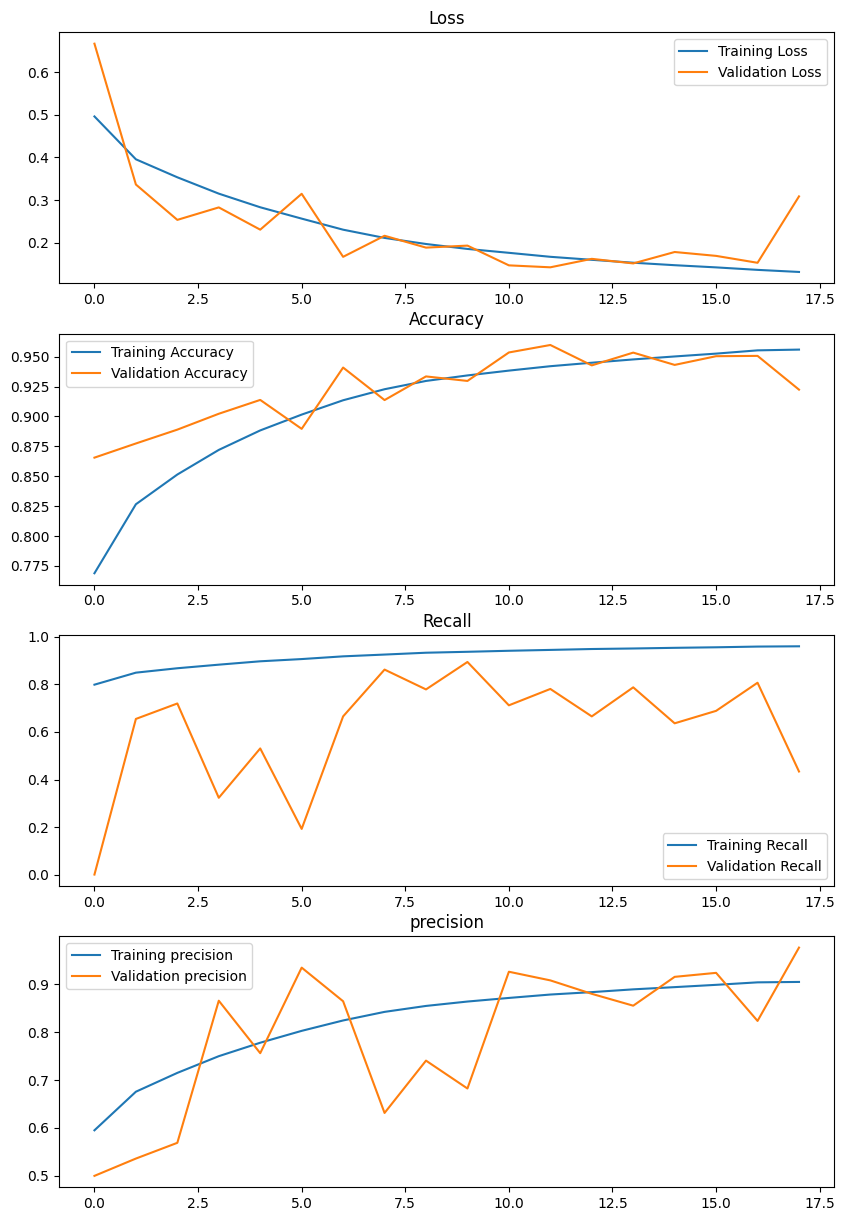

In [ ]:
plot_histories([model_g_history.history ], False )

In [ ]:
test_dataset = create_tf_dataset(test_data).batch(32)

In [ ]:
# latest model
loss, accuracy,precision, recall = model_g_custom.evaluate(test_dataset)

print("Loss: ", loss) 			#
print("Accuracy: ", accuracy) 	#
print("Recall: ", recall) 		#
print('Precision = ', precision)#


241/241 [==============================] - 7s 19ms/step - loss: 0.2846 - accuracy: 0.9287 - recall: 0.4439 - precision: 0.9818
Loss:  0.2845659852027893
Accuracy:  0.9286643862724304
Recall:  0.981776773929596
Precision =  0.4438723027706146


In [ ]:
# best model in terms of loss

from keras.models import load_model

loaded_model = load_model('./models/custom_g/best_val_loss.keras')
loss, accuracy, precision, recall = loaded_model.evaluate(test_dataset)

print("Loss: ", loss) 			# 0.2357979118824005
print("Accuracy: ", accuracy) 	# 0.9073157906532288
print("Recall: ", recall) 		# 0.4984551966190338
print("Precision: ", precision) # 0.6826516389846802



241/241 [==============================] - 6s 20ms/step - loss: 0.1319 - accuracy: 0.9619 - recall: 0.7930 - precision: 0.8933
Loss:  0.13186174631118774
Accuracy:  0.961858868598938
Recall:  0.8932714462280273
Precision:  0.792996883392334


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
